In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_2009 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df_2009, df_2010])

In [3]:
#월별로 date 데이터 변환
df['InvoiceDate_month'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y-%m'))

In [4]:
#일별로 date 데이터 변환
df['InvoiceDate_date'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y-%m-%d'))

In [5]:
#매출 컬럼 생성
df['sales'] = df['Quantity'] * df['Price']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Invoice            1067371 non-null  object        
 1   StockCode          1067371 non-null  object        
 2   Description        1062989 non-null  object        
 3   Quantity           1067371 non-null  int64         
 4   InvoiceDate        1067371 non-null  datetime64[ns]
 5   Price              1067371 non-null  float64       
 6   Customer ID        824364 non-null   float64       
 7   Country            1067371 non-null  object        
 8   InvoiceDate_month  1067371 non-null  object        
 9   InvoiceDate_date   1067371 non-null  object        
 10  sales              1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 97.7+ MB


# RFM 프레임워크
    
Recency - Frequency - Monetary라는 세 가지 요소를 가지고 고객을 분류하고자 함.
    
* Recency: 가장 최근에 결제한 날짜
* Frequency: 구매 횟수
* Monetary: 매출

In [7]:
#가장 최근 구매한 날짜
recent_date = pd.DataFrame(df.groupby(['Customer ID'])['InvoiceDate_date'].max().reset_index())

In [8]:
min(recent_date.InvoiceDate_date)

'2009-12-01'

In [9]:
max(recent_date.InvoiceDate_date)

'2011-12-09'

In [10]:
# 최근 3개월 동안 결제했는지로 recency 결정
recent_date['recency'] = recent_date.InvoiceDate_date > '2010-11-09'

In [11]:
# Frequency: 고객별 주문건수 확인
freq = pd.DataFrame(df.groupby(['Customer ID'])['Invoice'].count()).reset_index()

In [12]:
# Monetary: 고객별 주문금액 집계
monetary = pd.DataFrame(df.groupby(['Customer ID'])['sales'].sum()).reset_index()

In [13]:
rf = pd.merge(recent_date, freq, how='right', on='Customer ID')
rfm = pd.merge(rf, monetary, how='right', on='Customer ID')

In [14]:
del rfm['InvoiceDate_date']

# KMeans Clustering

* KMeans 알고리즘을 이용해 고객을 세분화해봅니다.
* 먼저 적정 수준의 그룹 수를 정한 뒤 그 그룹 개수로 고객을 세분화합니다.

In [15]:
from sklearn.cluster import KMeans

In [16]:
rfm = pd.get_dummies(rfm, columns=['recency'], drop_first = True)

In [17]:
rfm.set_index('Customer ID', inplace=True)

In [18]:
inertia = []

for i in range(2,10):
    model = KMeans(n_clusters=i)
    model.fit(rfm)
    inertia.append(model.inertia_)

<AxesSubplot:>

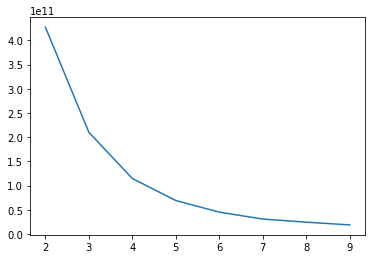

In [19]:
sns.lineplot(x=list(range(2,10)), y=inertia)

* inertia 값의 기울기가 더이상 크게 꺾이지 않은 지점으로 클러스터 개수를 정함
* 적정 클러스터의 개수 5개로 정하고 다시 클러스터링 진행

In [20]:
model = KMeans(n_clusters=5)
model.fit(rfm)

KMeans(n_clusters=5)

In [2]:
# 그룹별 라벨 값을 기존 데이터프레임에 'group' 컬럼으로 지정
rfm['group'] = model.labels_

In [22]:
#그룹별 고객의 수 확인
pd.DataFrame(rfm.groupby('group')['Invoice'].count())

,Invoice
group,
0,5584
1,5
2,2
3,27
4,324


In [23]:
# 고객층별 구매 건수 / 구매액 / 최근 구매 여부 평균 값 확인
summary = rfm.groupby('group').mean().reset_index()
summary

,group,Invoice,sales,recency_True
0,0,97.462751,1352.327728,0.760387
1,1,3976.600000,232620.822000,1.000000
2,2,2479.000000,560778.645000,1.000000
3,3,1973.814815,76720.727111,1.000000
4,4,623.450617,14632.016426,0.978395


<AxesSubplot:xlabel='group', ylabel='recency_True'>

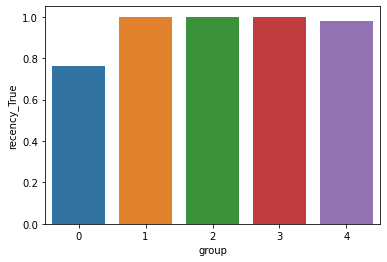

In [24]:
# 고객층별 최근 구매 여부의 평균값
sns.barplot(x='group', y='recency_True', data=summary)

<AxesSubplot:xlabel='group', ylabel='Invoice'>

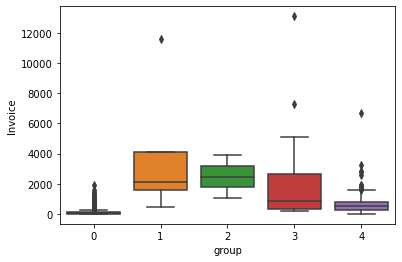

In [25]:
# 고객층별 구매 건수 boxplot 시각화
sns.boxplot(x='group', y='Invoice', data=rfm)

<AxesSubplot:xlabel='group', ylabel='sales'>

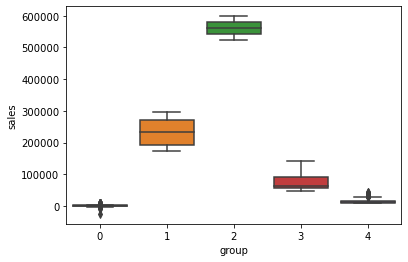

In [26]:
# 고객층별 구매액 boxplot 시각화
sns.boxplot(x='group', y='sales', data=rfm)

## 고객 그룹별 요약
* 0번 그룹: 최근 구매한 비율이 낮고 구매 건수 및 구매액이 모두 낮은 그룹
* 1번 그룹: 최근 구매한 비율이 100%에 달하고, 구매 건수가 비교적 많으나 구매액은 크게 높지 않은 고객층. 즉 자주 구매하지만 구매금액은 크지 않음.
* 2번 그룹: 최근 구매한 비율이 100%에 달하고, 구매 건수기 비교적 많으며 구매액이 최상위인 VIP 고객
* 3번 그룹: 최근 구매한 비율이 100%에 달하고, 구매 건수는 다소 낮으며 구매액도 낮은 고객층.
* 4번 그룹: 최근 구매 비율이 98%에 달하나 구매건수 및 구매액이 적은 그룹.

## 시사점

* 0번 그룹에 속한 회원이 다수를 차지해 고객 충성도가 낮은 것으로 파악됨.
* 3번/4번 그룹은 최근 구매 비율이 높으나 구매 건수/구매액 모두 적어 구매 금액별 쿠폰 발급 등으로 매출을 유도할 필요가 있어 보임.
* 2번 그룹처럼 VIP 성향을 보이는 고객이 어떤 품목을 구매했는지 확인하고 이들이 원하는 제품을 관리해야 함.